In [1]:
import pandas as pd

In [2]:
hotels = pd.read_csv("data/hotels.csv", sep=",")
hotels["launch_date"] = hotels["launch_date"].astype("datetime64[ns]")

In [3]:
print("Number of hotels with handy deployed: {}".format(hotels.shape[0]))

Number of hotels with handy deployed: 2530


In [4]:
print("Launch date range: {} to {}".format(min(hotels["launch_date"].dt.date), max(hotels["launch_date"].dt.date)))

Launch date range: 2012-12-08 to 2018-10-26


##### Let's see how handy has been growing in terms of hotel deployment:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date

before_201808 = hotels["launch_date"] < date(2018, 8, 1)
hotels_sum = hotels[before_201808][["launch_date", "destination_id"]].set_index("launch_date").resample("M").count()
hotels_sum

,destination_id
launch_date,
2012-12-31,1
2013-01-31,0
2013-02-28,0
2013-03-31,0
2013-04-30,0
2013-05-31,0
2013-06-30,0
2013-07-31,0
2013-08-31,1


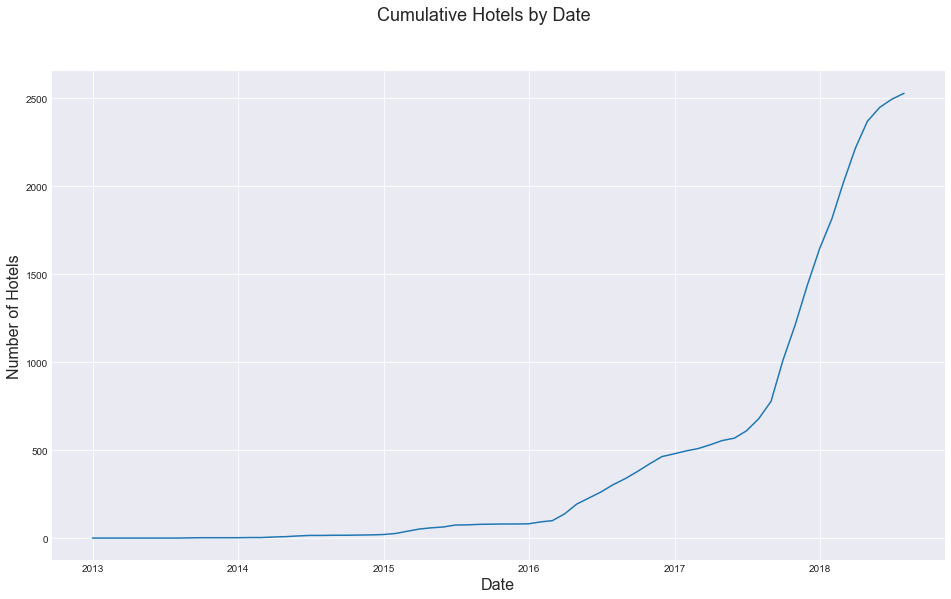

In [6]:
hotels_cum_sum = hotels_sum.cumsum()

sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
fig.suptitle("Cumulative Hotels by Date", fontsize=18)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Hotels", fontsize=16)
plt.plot(hotels_cum_sum)
plt.show()

##### List of cities with more than 10 hotels deployed:

In [7]:
hotels["geo_id"].value_counts()[hotels["geo_id"].value_counts() > 10]

g186338     208
g294265     144
g294217     134
g187791      81
g298566      66
g187147      60
g298564      45
g298560      31
g298207      31
g1066451     31
g274887      30
g1066444     29
g664891      27
g187849      27
g293916      25
g298224      25
g187895      23
g274707      22
g189400      21
g187497      21
g293913      20
g293974      20
g298106      18
g190454      18
g294458      18
g298562      17
g298249      16
g294197      15
g1066443     15
g188590      15
g298171      15
g293797      15
g187514      14
g1066457     14
g188057      12
g635613      11
g298173      11
g1066461     11
g298151      11
Name: geo_id, dtype: int64

##### So where are the handy cities? Without access to TripAdvisor API for the time being, let's try to obtain the list of locations through web crawling.

By passing just the `geo_id` after `https://en.tripadvisor.com.hk/Hotels-`, it'll be redirected to the page with list of hotels for that location, e.g. https://en.tripadvisor.com.hk/Hotels-g186338

![g186338 is London](img/geo_id_redirect.png)

`g186338`, the city with most number of hotels with handy deployed is London. Now let's hit them all!

In [ ]:
import requests
import re
import csv
from tqdm import tqdm

with open("data/locations.csv", "w+") as f:
    writer = csv.writer(f, delimiter=",")
    writer.writerow(["geo_id", "location"])

    for geo_id in tqdm(hotels["geo_id"].unique()):
        r = requests.get("https://en.tripadvisor.com.hk/Hotels-" + geo_id)
        # r.url sample : https://en.tripadvisor.com.hk/Hotels-g1010802-Garching_bei_Munchen_Upper_Bavaria_Bavaria-Hotels.html
        # extract the location data and replace _ with space, which will be used later in Google Maps search
        location = re.match("https:\/\/en.tripadvisor.com.hk\/Hotels-g\d+-(.+)-Hotels.html", r.url).group(1).replace("_", " ")
        writer.writerow([geo_id, location])

Let's save the list for later, which may come handy..

In [9]:
locations = pd.read_csv("data/locations.csv", sep=",")
hotels = hotels.merge(locations, on="geo_id", how="left")

In [10]:
hotels["location"].value_counts()[hotels["location"].value_counts() > 10]

London England                                              208
Singapore                                                   144
Hong Kong                                                   134
Rome Lazio                                                   81
Osaka Osaka Prefecture Kinki                                 66
Paris Ile de France                                          60
Kyoto Kyoto Prefecture Kinki                                 45
Minato Tokyo Tokyo Prefecture Kanto                          31
Sapporo Hokkaido                                             31
Fukuoka Fukuoka Prefecture Kyushu                            31
Budapest Central Hungary                                     30
Chuo Tokyo Tokyo Prefecture Kanto                            29
Macau                                                        27
Milan Lombardy                                               27
Bangkok                                                      25
Naha Okinawa Prefecture                 

##### Let's plot a heatmap to visualize the handy hotels.. We'll need to obtain the `latitude` and `longitude` for each location in order to plot it with `gmaps`.

In [ ]:
import gmaps

with open("gmaps.key", "r") as f:
    gmaps_key = f.readline()
gmaps.configure(api_key=gmaps_key) # Your Google API key

def get_lat_long(location):
    # sample request for Google Maps Geocoding API:
    # https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA&key=YOUR_API_KEY
    try:
        r = requests.get("https://maps.googleapis.com/maps/api/geocode/json?address=" + location.replace(" ", ",") + "&key=" + gmaps_key)
        lat = r.json()["results"][0]["geometry"]["location"]["lat"]
        long = r.json()["results"][0]["geometry"]["location"]["lng"]
        return lat, long
    except:
        print(location, r.json())    

locations["latlong"] = locations["location"].apply(get_lat_long)
locations["lat"] = locations["latlong"].apply(pd.Series)[0]
locations["long"] = locations["latlong"].apply(pd.Series)[1]
locations.drop(["latlong"], axis=1, inplace=True)

In [11]:
hotel_counts = hotels["geo_id"].value_counts().reset_index()
hotel_counts.columns = "geo_id", "hotel_count"
locations = locations.merge(hotel_counts, on="geo_id")

In [ ]:
locations.to_csv("data/locations.csv", sep=",", encoding="utf-8", index=False)

In [14]:
valid_locations = locations.dropna()
print("Locations with handy deployed")

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(valid_locations[["lat", "long"]]))
fig

Locations with handy deployed


Figure(layout=FigureLayout(height='420px'))

In [15]:
hotels[hotels.duplicated("destination_id", keep=False)].sort_values(by="destination_id")

,geo_id,destination_id,launch_date,location,lat,long,hotel_count
1198,g2361615,d10006000,2018-05-04,Province of Malaga Andalucia,36.721111,-4.421031,1
805,g187438,d10006000,2018-05-04,Malaga Costa del Sol Province of Malaga Andalucia,36.524807,-5.039054,1
420,g14135010,d10128482,2017-12-23,Dotombori Chuo Osaka Osaka Prefecture Kinki,34.667643,135.500052,2
2186,g298566,d10128482,2017-12-23,Osaka Osaka Prefecture Kinki,34.693738,135.502165,66
410,g14129743,d10223698,2018-02-28,Akasaka Minato Tokyo Tokyo Prefecture Kanto,35.665529,139.730703,4
140,g1066451,d10223698,2018-02-28,Minato Tokyo Tokyo Prefecture Kanto,35.658068,139.751599,31
332,g13806615,d10257221,2017-09-15,Gushan Kaohsiung,22.649587,120.268580,2
1768,g297908,d10257221,2017-09-15,Kaohsiung,22.627278,120.301435,4
350,g13808635,d1026343,2017-09-13,Yuchi Nantou,23.875385,120.918783,2
2289,g304160,d1026343,2017-09-13,Nantou,23.960998,120.971864,2


##### Turns out that `destination_id` is actually unique and is independent of `geo_id`. Which means that `https://en.tripadvisor.com.hk/Hotel_Review-destination_id` actually works.